In [5]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path) 

#from importlib import reload  # Python 3.4+

import pickle
import pandas as pd

#force reimport
if 'pygents.util' in sys.modules:
    del sys.modules['pygents.util']
if 'pygents.text' in sys.modules:
    del sys.modules['pygents.text']
if 'pygents.plot' in sys.modules:
    del sys.modules['pygents.plot']
if 'pygents.token' in sys.modules:
    del sys.modules['pygents.token']
if 'pygents.token_plot' in sys.modules:
    del sys.modules['pygents.token_plot']


from pygents.token import *
from pygents.text import *
from pygents.util import *
from pygents.plot import plot_bars, plot_dict, matrix_plot
from pygents.token_plot import *

In [6]:
path = '../../nlp/corpora/Chinese/'
test_df = pd.read_csv(os.path.join(path,'magicdata/zh_en_ru_100/CORPUS_ZH_EN_RU.txt'),delimiter='\t')
test_texts = list(test_df['en'])
print(len(test_texts))
test_df[['en']]

100


,en
0,What about medical insurance? As for my family...
1,"For those who have insurance, according to the..."
2,Need to realize the importance of having insur...
3,"In fact, this phenomenon is indeed very common..."
4,It is really necessary for this generation of ...
...,...
95,Ant Insurance does not only offer car insuranc...
96,"However, when buying a house, except for the d..."
97,This kind of financial investment has certain ...
98,"If your investment orientation is right, then ..."


In [26]:
ngram_params = [[1],[2],[3],[4],[5],[6],[7],[1,2],[2,3],[1,2,3],[1,2,3,4],[4,5,6,7],[1,2,3,4,5],[1,2,3,4,5,6,7]]
model_thresholds = [0,0.0001,0.001,0.01,0.1]
token_thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#ngram_params = [[1],[2]]
#model_thresholds = [0,0.0001]
#token_thresholds = [0.1,0.4,0.6,0.9]
ref_tokenizer = DelimiterTokenizer()


In [27]:
def evaluate_comnpression(texts,tokenized_texts):
    text_len = 0
    tokenized_text_len = 0
    tokens_count = 0
    lexicon = {}
    for text in texts:
        text_len += len(text)
    for tokenized_text in tokenized_texts:
        tokens_count += len(tokenized_text)
        for token in tokenized_text:
            tokenized_text_len += len(token)
            dictcount(lexicon,token)
    tokens_len = 0
    for token in lexicon:
        tokens_len += len(token)
    assert text_len == tokenized_text_len
    return (tokens_len + tokens_count) / text_len
        

def evaluate_tokenizer_f1_compratio(texts,real_tokenizer,test_tokenizer,nospaces=False,expected_collector=None,actual_collector=None,debug=False):
    avg_f1 = 0
    count = 0
    tokenized_texts = []
    for text in texts:
        expected = real_tokenizer.tokenize(text)
        if nospaces:
            remove_all(expected,' ')
        tokens = test_tokenizer.tokenize(text if not nospaces else text.replace(' ','')) # nospaces=True complicates the problem removing spaces
        tokenized_texts.append(tokens)
        if not expected_collector is None:
            dictcount(expected_collector,expected)
        if not actual_collector is None:
            dictcount(actual_collector,tokens)
        f1 = calc_f1(expected,tokens)
        if debug:
            print(text)
            print(expected)
            print(tokens)
            print(round(f1,2))
        avg_f1 += f1
        count += 1
    return round(avg_f1/count,2), round(evaluate_comnpression(texts,tokenized_texts),2)


def evaluate_freedom_tokenizer_compression(test_texts,ref_tokenizer,tokenizer,ngram_params,thresholds,plot=True,title=None,nospaces=False,debug=False):
    rlist = []
    crlist = []
    for nlist in ngram_params:
        for threshold in thresholds: 
            tokenizer.set_options(nlist = nlist, threshold=threshold)
            avg_f1, compratio = evaluate_tokenizer_f1_compratio(test_texts,ref_tokenizer,tokenizer,nospaces=nospaces,debug=False)
            if debug:
                print(nlist,threshold,avg_f1)
            rlist.append((nlist,threshold,avg_f1))
            crlist.append((nlist,threshold,compratio))
    if plot:
        r,c,m = list2matrix(rlist)
        matrix_plot(r,c,m,1.0,'F1:'+title,vmin=0.0)
        r,c,m = list2matrix(crlist)
        matrix_plot(r,c,m,1.0,'C%:'+title,vmin=0.0)


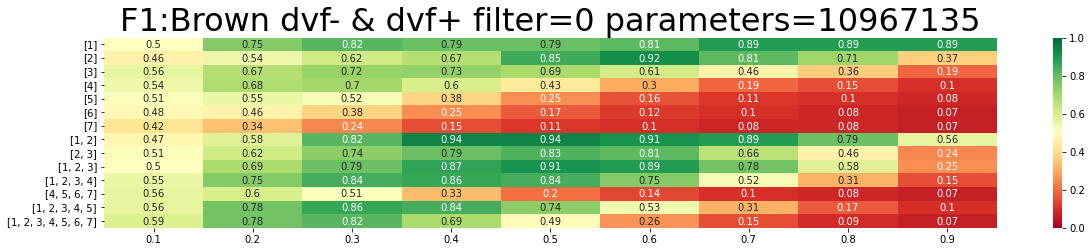

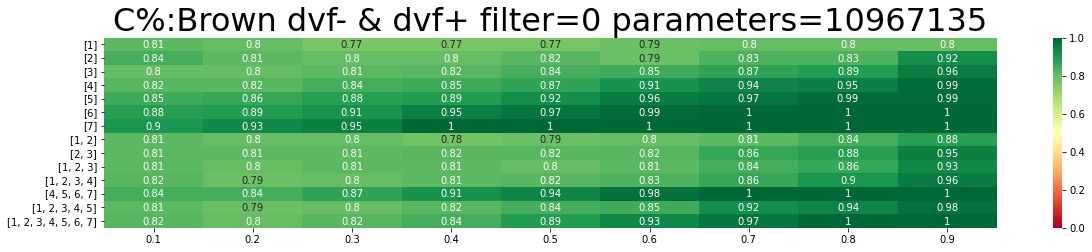

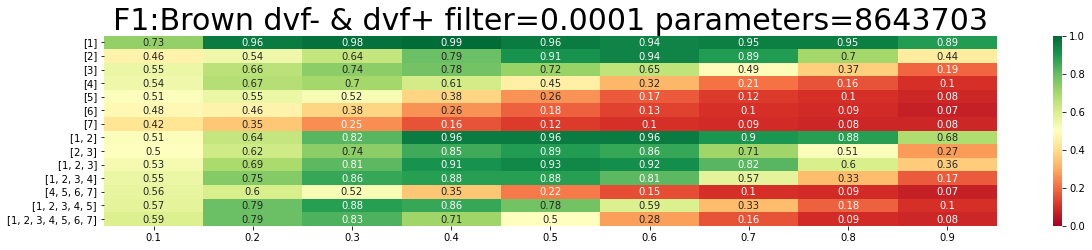

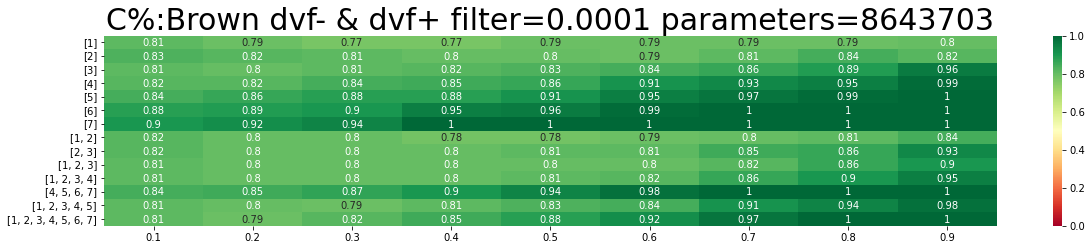

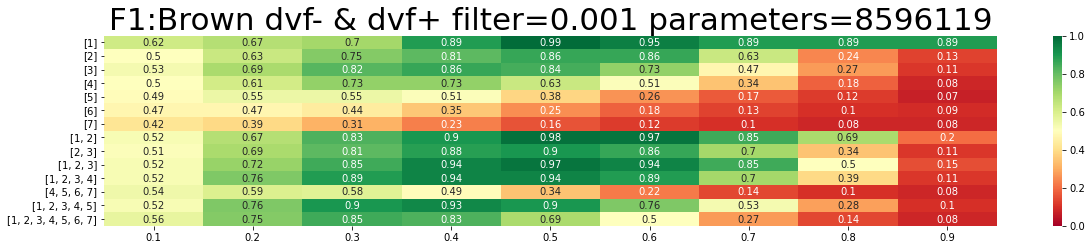

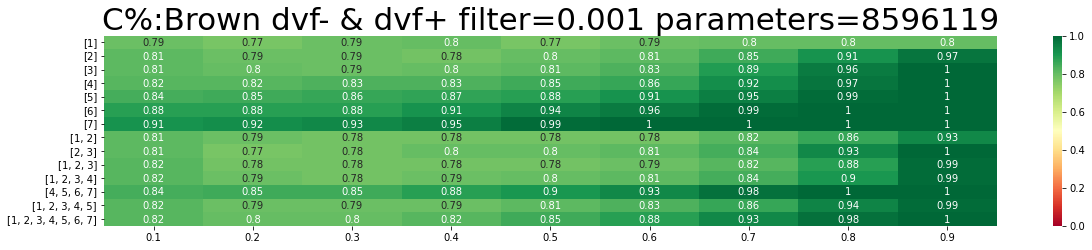

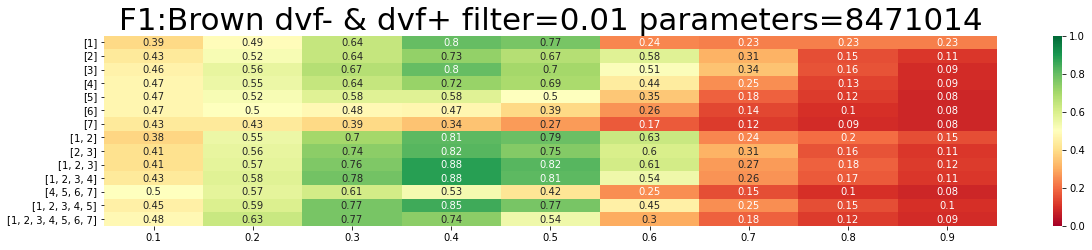

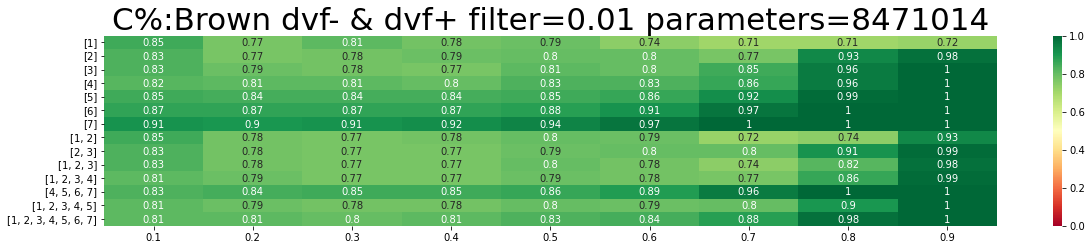

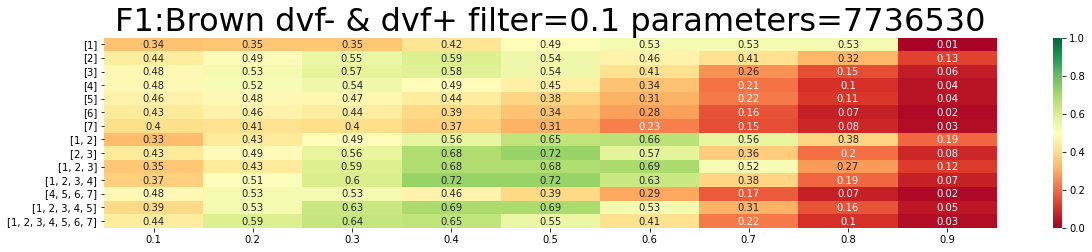

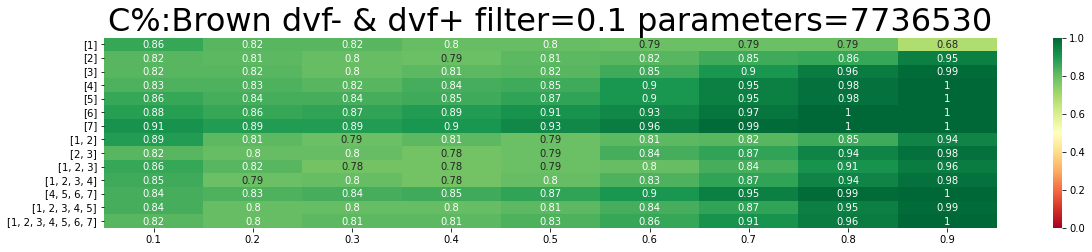

In [28]:
base = FreedomTokenizer(name='data/models/brown_nolines_chars_7a',max_n=7,mode='chars',debug=False)
title = 'Brown dvf- & dvf+'
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base.model,model_threshold)
    parameters = base.count_params()
    evaluate_freedom_tokenizer_compression(test_texts,ref_tokenizer,FreedomBasedTokenizer(base,'dvf-','dvf+'),
        ngram_params,token_thresholds,title="{} filter={} parameters={}".format(title,model_threshold,parameters))
del base


In [21]:
print(evaluate_comnpression(["aaaabbbbaaaabbbb"],[["aaaabbbbaaaabbbb"]]))
print(evaluate_comnpression(["aaaabbbbaaaabbbb"],[["aaaabbbb"],["aaaabbbb"]]))
print(evaluate_comnpression(["aaaabbbbaaaabbbb"],[["aaaa"],["bbbb"],["aaaa"],["bbbb"]]))
print(evaluate_comnpression(["aaaabbbbaaaabbbb"],[["aa"],["aa"],["bb"],["bb"],["aa"],["aa"],["bb"],["bb"]]))
print(evaluate_comnpression(["aaaabbbbaaaabbbb"],[["a"],["a"],["a"],["a"],["b"],["b"],["b"],["b"],["a"],["a"],["a"],["a"],["b"],["b"],["b"],["b"]]))


1.0625
0.625
0.75
0.75
1.125


In [25]:
a = [-1,-2,-3]
b = [10,20,30]
np.corrcoef(a,b)

array([[ 1., -1.],
       [-1.,  1.]])

In [ ]:
#TODO check tokenizatoion compress-ability
